<h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Kaggle - Gravitational Wave Detection EDA and Baseline TensorFlow / Keras Model - Detailed Video in my YouTube Channel</b><a id="0"></a></h1>

<a href="https://youtu.be/UeI4-kyuAwI?list=PLxqBkZuBynVS8mDTc8ZGermXiS-32pR2y"><h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Link to my YouTube Video</b></h1></a>

[![IMAGE ALT TEXT](https://imgur.com/niQAD58.png)](https://youtu.be/UeI4-kyuAwI?list=PLxqBkZuBynVS8mDTc8ZGermXiS-32pR2y "Kaggle - Gravitational Wave Detection EDA and Baseline TensorFlow / Keras Model - Detailed Video in my YouTube Channel")

-----------

In this competition you are provided with a training set of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers (LIGO Hanford, LIGO Livingston, and Virgo). Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal. The task is to identify when a signal is present in the data (target=1).

So we need to use the training data along with the target value to build our model and make predictions on the test IDs in form of probability that the target exists for that ID.

So basically data-science helping here by building models to filter out this noises from data-streams (which includes both noise frequencies and Gravitational Waves frequencies) so we can single out frequencies for Gravitational-Waves. This is very well-explained by by Professor Rana Adhikari of Caltech and a member of the LIGO team, who were the first to measure gravitational waves. See his [interview here](https://youtu.be/1D2j8nTjOZ4?t=1946)


## Basic Description of the Data Provided

We are provided with a train and test set of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers:

- LIGO Hanford

- LIGO Livingston

- Virgo

Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal.

The task is to identify when a signal is present in the data (target=1).

Each .npy data file contains 3 time series (1 coming for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

And we have a total of 5,60,000 files, each file of dimension of 3 * 4096, this turns out to be a huge time series

In [1]:
# ************ START OF ALL ONE-TIME-ONLY-CODES  *************

# Installation of Kaggle package - ONE TIME ONLY-Just before the one-time pulling of data from 
# Kaggle dataset to my G-Drive
# !pip install --upgrade --force-reinstall --no-deps kaggle

# TO ACTUALLY IMPORT KAGGLE DATA TO G-DRIVE - ONE TIME CODE
# os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/Kaggle_Datasets'
# os.chdir('/content/gdrive/MyDrive/G2Net_Gravitational_Waves')
# !kaggle competitions download -c g2net-gravitational-wave-detection

#Unzip Data - ONE TIME ONLY
# !unzip /content/gdrive/MyDrive/G2Net_Gravitational_Waves/g2net-gravitational-wave-detection.zip

# ************ END OF ALL ONE-TIME-ONLY-CODES  *************

### Special Note on gwpy and matplotlib version compatibility

Main Tracking Issue - https://github.com/gwpy/gwpy/issues/1398

Other Issue -

https://github.com/matplotlib/matplotlib/issues/20901

https://github.com/googlecolab/colabtools/issues/2207

### Source of Problem and Temporary workaround 

In matplotlib 3.2.2

```
import matplotlib.pyplot as plt
pyplot.new_figure_manager.__module__
```

yields: `matplotlib.backend_bases`


In matplotlib 3.4.3 it yields: `matplotlib.pyplot`

This is breaking:

So, as suggested [gwpy/gwpy#1398](https://github.com/gwpy/gwpy/issues/1398) - 

#### So the temporary workaround for now in Colab is to use an earlier version of matplotlib-

```
!pip install matplotlib==3.2.2
```

With `3.2.2` it works fine.

In [2]:
# ********** FOR GOOGLE DRIVE AND COLAB *****************

# from google.colab import drive
# drive.mount('/content/gdrive')
# import os

# !python -m pip install gwpy
# !pip install --upgrade --force-reinstall --no-deps gwpy
# !pip install astropy
# !pip install nnAudio
# !pip install colorama

# !pip install --upgrade --force-reinstall --no-deps matplotlib

# !pip install --force-reinstall --no-deps matplotlib==3.2.2
# For running in Colab I have to have a previous version of matplotlib
# This for Gihut Issue > https://github.com/gwpy/gwpy/issues/1398
# More details are in my note in previous cell

# !pip install gwosc
# !pip install dqsegdb2
# !pip install ligotimegps

In [3]:
import pandas as pd
import seaborn as sns
from scipy import signal
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
import random
from colorama import Fore, Back, Style
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

import torch
from nnAudio.Spectrogram import CQT1992v2

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2021-08-25 20:06:28.967551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-25 20:06:28.967585: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# What are Gravitational Waves?

Gravitational waves are 'ripples' in space-time caused by some of the most violent and energetic processes in the Universe. Albert Einstein predicted the existence of gravitational waves in 1916 in his general theory of relativity. Einstein's mathematics showed that massive accelerating objects (such as neutron stars or black holes orbiting each other) would disrupt space-time in such a way that 'waves' of undulating space-time would propagate in all directions away from the source. These cosmic ripples would travel at the speed of light, carrying with them information about their origins, as well as clues to the nature of gravity itself.

The strongest gravitational waves are produced by cataclysmic events such as colliding black holes, supernovae (massive stars exploding at the end of their lifetimes), and colliding neutron stars. Other waves are predicted to be caused by the rotation of neutron stars that are not perfect spheres, and possibly even the remnants of gravitational radiation created by the Big Bang.

[Source](https://www.ligo.caltech.edu/page/what-are-gw)

On September 14, 2015 for the very first time, LIGO (Laser Interferometer Gravitational-Wave Observatory) physically sensed the undulations in spacetime caused by gravitational waves generated by two colliding black holes 1.3 billion light-years away. LIGO's discovery will go down in history as one of humanity's greatest scientific achievements.

While the processes that generate gravitational waves can be extremely violent and destructive, by the time the waves reach Earth they are thousands of billions of times smaller! In fact, by the time gravitational waves from LIGO's first detection reached us, the amount of space-time wobbling they generated was a 1000 times smaller than the nucleus of an atom! Such inconceivably small measurements are what LIGO was designed to make.



# Time Domain vs Frequency Domain Analysis ?

A **Time domain analysis** is an analysis of physical signals, mathematical functions, or time series of economic or environmental data, in reference to time. Also, in the time domain, the signal or function's value is understood for all real numbers at various separate instances in the case of discrete-time or the case of continuous-time. Furthermore, an oscilloscope is a tool commonly used to see real-world signals in the time domain.

Moreover, a time-domain graph can show how a signal changes with time.

In **Frequency domain** your model/system is analyzed according to it's response for different frequencies. How much of the signal lie in different frequency range. Theoretically signals are composed of many sinusoidal signals with different frequencies (Fourier series), like triangle signal, its actually composed of infinite sinusoidal signal (fundamental and odd harmonics frequencies).

We can move from time domain to frequency domain with the help of Fourier transform.

---

# The problem of glitches in LIGO data and how Data Science can help

I quote from [this](https://arxiv.org/pdf/1911.11831.pdf) paper named "Efficient Gravitational-wave Glitch Identification from Environmental Data Through
Machine Learning"

![Imgur](https://imgur.com/jyZ6ydh.png)

It goes on to say, Modern interferometric gravitational-wave (GW) detectors are highly complex and sensitive instruments. Each detector is sensitive not only to gravitational radiation, but also to noise from sources including the physical environment, seismic activity, and complications in the detector itself. The output data of these
detectors is therefore also highly complex. In addition to
the desired signal, the GW data stream contains sharp
lines in its noise spectrum and non-Gaussian transients,
or “glitches,” that are not astrophysical in origin.
Instrumental artifacts in the GW data stream can be
mistaken for short-duration, unmodeled GW events, and
noisy data can also decrease the confidence in compact
binary detections, sometimes by orders of magnitude

---

### References and Further Reading on Gravitational Waves

https://www.nature.com/articles/d41586-018-04157-6

https://dcc.ligo.org/public/0122/P1500260/015/errata_authors_Martynov_PRD_AF.pdf - Has good Noise sensitivity data

---

### What are .npy files ?

It is a standard binary file format for persisting a single arbitrary NumPy array on disk. The format stores all of the shape and data type information necessary to reconstruct the array correctly even on another machine with a different architecture. The format is designed to be as simple as possible while achieving its limited goals. The implementation is intended to be pure Python and distributed as part of the main numpy package.

**This file format makes incredibly fast reading speed enhancement over reading from plain text or CSV files.**

### Sampling frequency in a TimeSeries

The sampling frequency, or sample rate, is the number of equal-spaced samples per unit of time. For instance, if you have 96 equally spaced observation per day, then you sampling rate is 96/day, or 96/24/3600=0.0011 Hz. Hz, which means per second, is widely used for sample rate.

In [4]:
# Checking the contents of one file

# Google-Drive Root Directory
root_dir = "/content/gdrive/MyDrive/G2Net_Gravitational_Waves/"

# LOCAL ROOT DIRECTORY
# root_dir = "../input/g2net-gravitational-wave-detection/"

file = root_dir + 'train/0/0/0/000a5b6e5c.npy'
data = np.load(file)
print(data.shape)
print(data)
# print(data[0, :].shape)
# print(data[1, :].shape)
# print(data[2, :].shape)
print("data[0, :] is ", data[0, :])
# data_1

(3, 4096)
[[-3.82980864e-21 -3.88290722e-21 -3.89583068e-21 ...
   1.00965251e-20  9.68836567e-21  9.75052802e-21]
 [-5.39587907e-21 -5.86718917e-21 -5.59127863e-21 ...
  -3.90359733e-21 -4.08026656e-21 -3.59755890e-21]
 [-2.08338130e-21 -2.78123460e-21 -2.56792922e-21 ...
   1.62472677e-21  1.92169973e-21  1.69866822e-21]]
data[0, :] is  [-3.82980864e-21 -3.88290722e-21 -3.89583068e-21 ...
  1.00965251e-20  9.68836567e-21  9.75052802e-21]


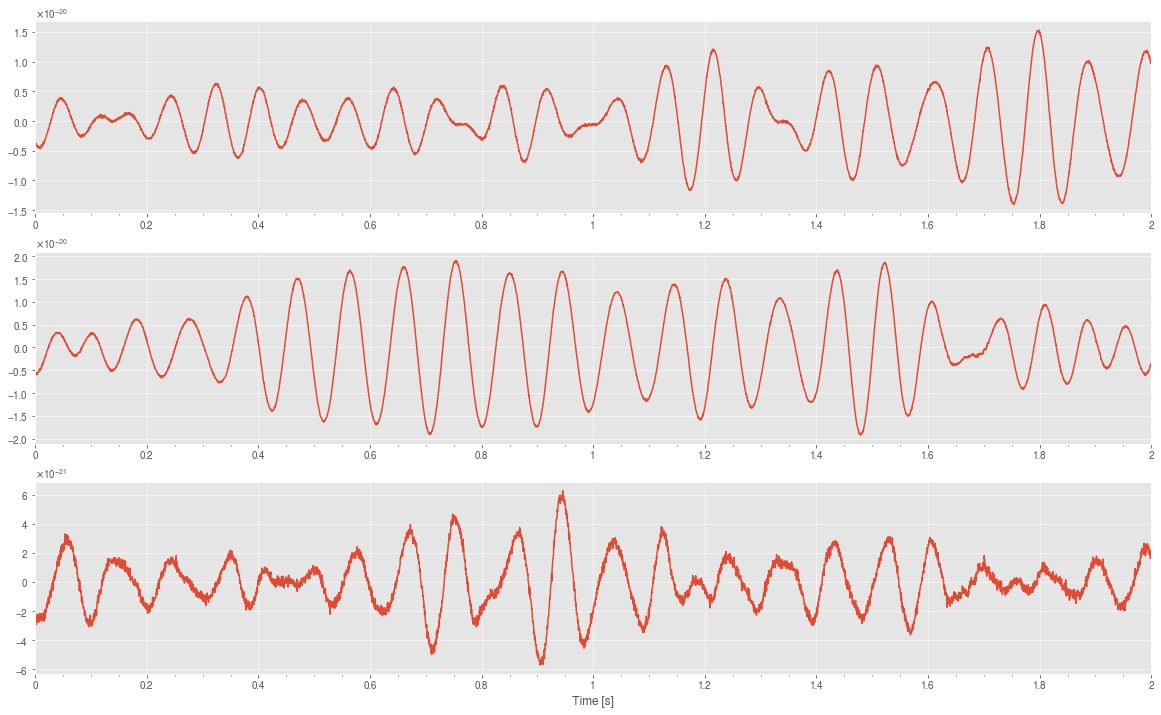

In [5]:
# The gwpy's TimeSeries function expects array-like input data array as its first argument
# and sample_rate : float, Quantity, optional the rate of samples per second (Hertz)
def get_tseries_from_file(file_name):
  t_data = np.load(file_name)
  tseries1 = TimeSeries(t_data[0,:], sample_rate=2048)
  tseries2 = TimeSeries(t_data[1,:], sample_rate=2048)
  tseries3 = TimeSeries(t_data[2,:], sample_rate=2048)
  return tseries1, tseries2, tseries3

''' Multi-data plots with gwpy.plot

https://gwpy.github.io/docs/latest/plot/index.html#multi-data-plots - 

GWpy enables trivial generation of plots with multiple datasets. The Plot constructor will accept an arbitrary collection of data objects and will build a figure with the required geometry automatically. By default, a flat set of objects are shown on the same axes: 

separate=True can be given to show each dataset on a separate Axes

The returned object is a Plot, a sub-class of matplotlib.figure. Figure adapted for GPS time-stamped data. Customisations of the figure or the underlying Axes can be done using standard matplotlib methods. Hence I can use .gca()

.gac() - Get the current Axes instance on the current figure matching the given keyword args, or create one. The plt.gca() function gets the current axes so that you can draw on it directly. 

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html

'''

def plot_tseries(t1, t2, t3):
  plot = Plot(t1, t2, t3, separate=True, sharex=True, figsize=[20, 12])
  ax = plot.gca()
  ax.set_xlim(0, 2)
  ax.set_xlabel('Time [s]')
  plt.show()
  
file_1 = root_dir + 'train/0/0/0/000a5b6e5c.npy'
  
tseries1, tseries2, tseries3 = get_tseries_from_file(file_1)

# Plotting the 3 TimeSeries
plot_tseries(tseries1, tseries2, tseries3)
  

## Load the .npy files from all the nested folder-structure and get the ids from file names

In [6]:
train_labels = pd.read_csv(root_dir + "/training_labels.csv")
print(Fore.YELLOW + 'Dataset has ', Style.RESET_ALL + "{} Observations".format(train_labels.shape[0]) )

print(Fore.MAGENTA + "Printing first 5 Labels: ", Style.RESET_ALL )
display(train_labels.head())

Dataset has  560000 Observations
Printing first 5 Labels:  


,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [7]:
# Construct a Training dataframe for all the available .npy files 

# Get all the file file path from all 4-labels of nested folder structure
files_paths = glob(root_dir + '/train/*/*/*/*')
''' The glob module finds all the pathnames matching a specified pattern according to the rules 
used by the Unix shell, although results are returned in arbitrary order. 
No tilde expansion is done, but *, ?, and character ranges expressed with [] will be correctly matched. 
We can use glob to search for a specific file pattern, or perhaps more usefully, search for files where the 
filename matches a certain pattern by using wildcard characters.

'''

# get the list of ids from the .npy files
ids_from_npy_files = [path.split("/")[-1].split(".")[0] for path in files_paths]
# [-1] means the last element in a sequence,
# print(ids_from_npy_files)

# get a dataframe with paths and ids of those .npy files
df_path_id = pd.DataFrame({'path': files_paths, 'id':ids_from_npy_files})
df_path_id.head()

# merging that above df with the target
df_train = pd.merge(left=train_labels, right=df_path_id, on='id')
display(df_train.head())

# verifying the shape of the merged df has 5,60,000 rows and 3 columns
df_train.shape


,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection//t...
1,00001f4945,0,../input/g2net-gravitational-wave-detection//t...
2,0000661522,0,../input/g2net-gravitational-wave-detection//t...
3,00007a006a,0,../input/g2net-gravitational-wave-detection//t...
4,0000a38978,1,../input/g2net-gravitational-wave-detection//t...


(560000, 3)

In [8]:
# Classify the the 2 classes of targets of 1 and 0
target_1_df_train = df_train[df_train.target == 1]
target_0_df_train = df_train[df_train.target == 0]
print("Class distribution of Target: \n ", train_labels.target.value_counts())
display(target_1_df_train.head())

Class distribution of Target: 
  0    280070
1    279930
Name: target, dtype: int64


,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection//t...
4,0000a38978,1,../input/g2net-gravitational-wave-detection//t...
5,0000bb9f3e,1,../input/g2net-gravitational-wave-detection//t...
7,0000d61b7b,1,../input/g2net-gravitational-wave-detection//t...
8,0001016d12,1,../input/g2net-gravitational-wave-detection//t...


Text(0.5, 1.0, 'Target Class Distribution')

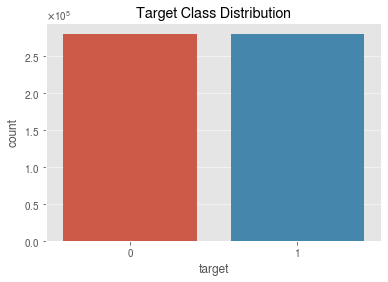

In [9]:
sns.countplot(x = 'target' , data=train_labels)
plt.title('Target Class Distribution')

# Basic CQT EDA and A quick Note on nnAudio and CQT

### Q-Transform

The constant quality factor transform (CQT), introduced by J.C. Brown in 1988, is an interesting alternative to the windowed Fourier transform (STFT / Short Time Fourier Transform) or wavelets, for time-frequency analysis.

The constant-Q transform transforms a data series to the frequency domain. It is related to the Fourier transform.
In general, the transform is well suited to musical data and proves useful where frequencies span several octaves.It is more useful in the identification of instruments.

Unlike the Fourier transform, but similar to the mel scale, the constant-Q transform (Wikipedia) uses a logarithmically spaced frequency axis. The original paper reference below

[Judith C. Brown, "Calculation of a constant Q spectral transform," J. Acoust. Soc. Am., 89(1):425–434, 1991.](http://academics.wellesley.edu/Physics/brown/pubs/cq1stPaper.pdf)

[From Wikipedia](https://en.wikipedia.org/wiki/Constant-Q_transform) - In mathematics and signal processing, the constant-Q transform, simply known as CQT transforms a data series to the frequency domain. It is related to the Fourier transform[1] and very closely related to the complex Morlet wavelet transform. In general, the transform is well suited to musical data, and this can be seen in some of its advantages compared to the fast Fourier transform. As the output of the transform is effectively amplitude/phase against log frequency, fewer frequency bins are required to cover a given range effectively, and this proves useful where frequencies span several octaves. As the range of human hearing covers approximately ten octaves from 20 Hz to around 20 kHz, this reduction in output data is significant.

A Constant Q transform is a variation on the Discrete Fourier Transform (DFT). In other words, it is a type of wavelet transform.

I only have a casual understanding of both types of transforms myself, so take what I'm saying with a grain of salt.

A standard DFT uses a constant window size throughout all frequencies. This typically leads to a pretty consistent, fully continuous transform. However, the constant bin size for all frequencies leads to some problems when you map frequency on a logarithmic scale. Specifically, peaks on the lower end are incredibly wide (sometimes up to half an octave), lacking any sort of detail.

This is an issue for emulating human perception because humans perceive frequency on a logarithmic scale.

A Constant Q transform seeks to solve this problem by increasing the window size for lower frequencies, and alleviate some of the computational strain caused by this by reducing the window size used for high frequencies. It's pretty effective at this, but has a few drawbacks.

The computational complexity of a Constant Q transform is only slightly larger than that of a standard DFT, but because the window size changes per frequency, it is impossible to apply the typical optimizations of the FFT to a Constant Q transform.

In other words, a Constant Q transform will yield better results where low frequencies and logarithmic frequency mapping are concerned.

The transform exhibits a reduction in frequency resolution with higher frequency bins, which is desirable for auditory applications. The transform mirrors the human auditory system, whereby at lower-frequencies spectral resolution is better, whereas temporal resolution improves at higher frequencies.

CQT refers to a time-frequency representation where the frequency bins are geometrically spaced
and the Q-factors (ratios of the center frequencies to bandwidths) of all bins are equal.


### nnAudio

**nnAudio** is an audio processing toolbox using PyTorch convolutional neural network as its backend. By doing so, spectrograms can be generated from audio on-the-fly during neural network training and the Fourier kernels (e.g. or CQT kernels) can be trained. **Kapre** and **torch-stft** have a similar concept in which they also use 1D convolution from Keras and PyTorch to do the waveforms to spectrogram conversions. Other GPU audio processing tools are torchaudio and tf.signal. But they are not using the neural network approach, and hence the Fourier basis can not be trained.


From [this](https://www.readcube.com/articles/10.1109%2Faccess.2020.3019084) Paper

"nnAudio, a new neural network-based audio processing framework with graphics processing unit (GPU) support that leverages 1D convolutional neural networks to perform time domain to frequency domain conversion. It allows on-the-fly spectrogram extraction due to its fast speed, without the need to store any spectrograms on the disk. Moreover, this approach also allows back-propagation on the waveforms-to-spectrograms transformation layer, and hence, the transformation process can be made trainable, further optimizing the waveform-to-spectrogram transformation for the specific task that the neural network is trained on. All spectrogram implementations scale as Big-O of linear time with respect to the input length. nnAudio, however, leverages the compute unified device architecture (CUDA) of 1D convolutional neural network from PyTorch, its short-time Fourier transform (STFT), Mel spectrogram, and constant-Q transform (CQT) implementations are an order of magnitude faster than other implementations using only the central processing unit (CPU)."



In [10]:
# First quickly check the shape of my df_train that I earlier defined
df_train.head()

,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection//t...
1,00001f4945,0,../input/g2net-gravitational-wave-detection//t...
2,0000661522,0,../input/g2net-gravitational-wave-detection//t...
3,00007a006a,0,../input/g2net-gravitational-wave-detection//t...
4,0000a38978,1,../input/g2net-gravitational-wave-detection//t...


In [11]:
waves_from_each_file = np.load(df_train.loc[2, 'path'])
print("waves_from_each_file shape: ", waves_from_each_file.shape)
waves_stacked = np.hstack(waves_from_each_file)
print("HStacked waves_from_each_file shape: ", waves_stacked.shape)


waves_from_each_file shape:  (3, 4096)
HStacked waves_from_each_file shape:  (12288,)


CQT kernels created, time used = 0.0577 seconds


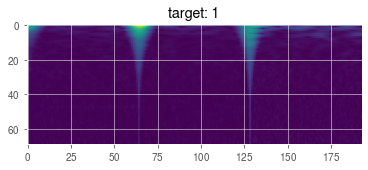

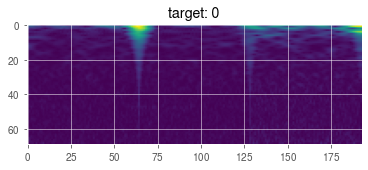

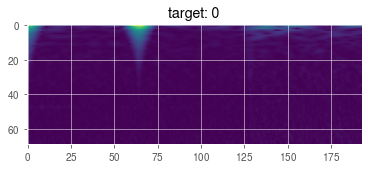

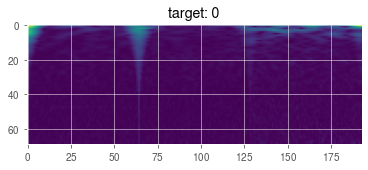

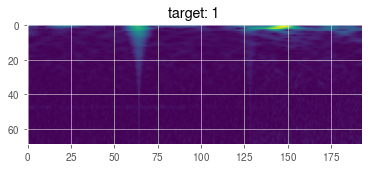

In [12]:
# Function to show the CQT Spectogram
def get_cqt_spectrogram(
    waves_from_each_file,
    transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64),
):
    stacked_waves_from_each_file = np.hstack(waves_from_each_file)
    stacked_waves_from_each_file = stacked_waves_from_each_file / np.max(
        stacked_waves_from_each_file
    )
    stacked_waves_from_each_file = torch.from_numpy(stacked_waves_from_each_file).float()
    cqt_image = transform(stacked_waves_from_each_file)
    return cqt_image


for i in range(5):
  waves = np.load(df_train.loc[i, 'path'])
  cqt_image = get_cqt_spectrogram(waves)
  # print("cqt_image ", i, cqt_image)
  target = df_train.loc[i, 'target']
  plt.imshow(cqt_image[0])
  plt.title(f"target: {target}")
  plt.show()

In above **sr** represents Sampling rate.
Sampling rate or Sampling frequency is the rate at which we are capturing amplitudes. In other words, it is just the number of data points recorded per second. These amplitudes can be electric or magnetic fileds in the case of light waves, current or voltage in the case of digital signals and pressure or displacement values for the case of sound waves.

### Plotting (KDE, Boxplot, and Timeseries)

As we are provided with a train and test set of time series data from a network of 3 gravitational wave interferometers:

- LIGO Hanford

- LIGO Livingston

- Virgo


In [13]:
# Defining a multi-plot function
# And I am going to call the 3 series as Series-1, Series-2 and Series-3
def multi_plot(series, plot_type, target):
    """
    Plot multiple subplots based on the given series and plot type.

    Args:
        series (list): List of series to plot.
        plot_type (str): Type of plot to generate ('box', 'kde', or 'time').
        target (str): Target label for the plot.

    Returns:
        None
    """
    if plot_type == 'box' or plot_type == 'kde':
      plt.figure(figsize=(20, 2))
    else:
      plt.figure(figsize=(15,12))

    for idx in range(3):
      if plot_type == 'box':
          plt.subplot(1, 3, idx+1)
          sns.boxplot(series[idx:idx+1], color = 'b')

      elif plot_type == 'kde':
            plt.subplot(1, 3, idx+1)
            sns.kdeplot(series[idx], color = 'g', shade=True, lw=2, alpha=0.5)
      else:
        plt.subplot(3, 1, idx+1) # As in the case of 'time' based plot, I wan 3 rows
        plt.plot(series[idx: idx+1].T, color= 'r')
        plt.title("\nSeries-" + str(idx+1))

    if plot_type == 'box':
      plt.suptitle("Box Plots(target = " + target + ")")
    elif plot_type == 'kde':
      plt.suptitle("Probability Distribution Plots(target = " + target + ")")
    else:
      plt.suptitle("Time Distribution of Signals - Spans 2 sec, Sampled at 2,048 Hz(target = " + target + ")")
        

  

../input/g2net-gravitational-wave-detection//train/f/f/7/ff7d0fd135.npy


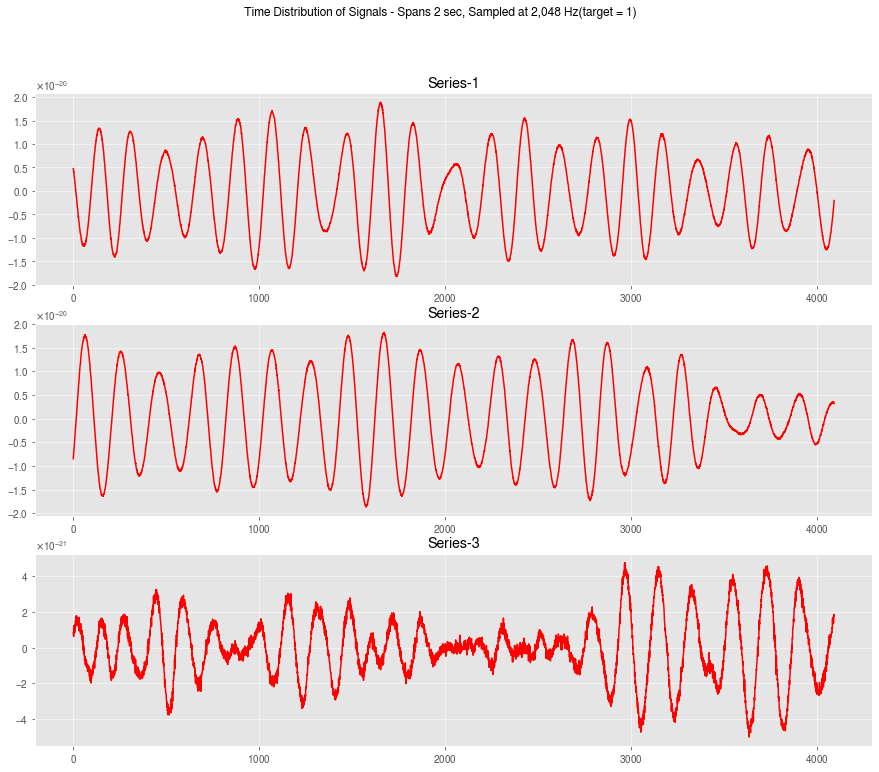

In [14]:
# Extract 1 random element from the target_1_df_train
# using random_state to ensure the reproducibility of the examples.
target_1_rand_sample_file = target_1_df_train.sample(1).path.values[0]
print(target_1_rand_sample_file)

selected_rand_series_1 = np.load(target_1_rand_sample_file)

multi_plot(selected_rand_series_1, 'time', "1")


../input/g2net-gravitational-wave-detection//train/3/8/8/3887c0c01e.npy


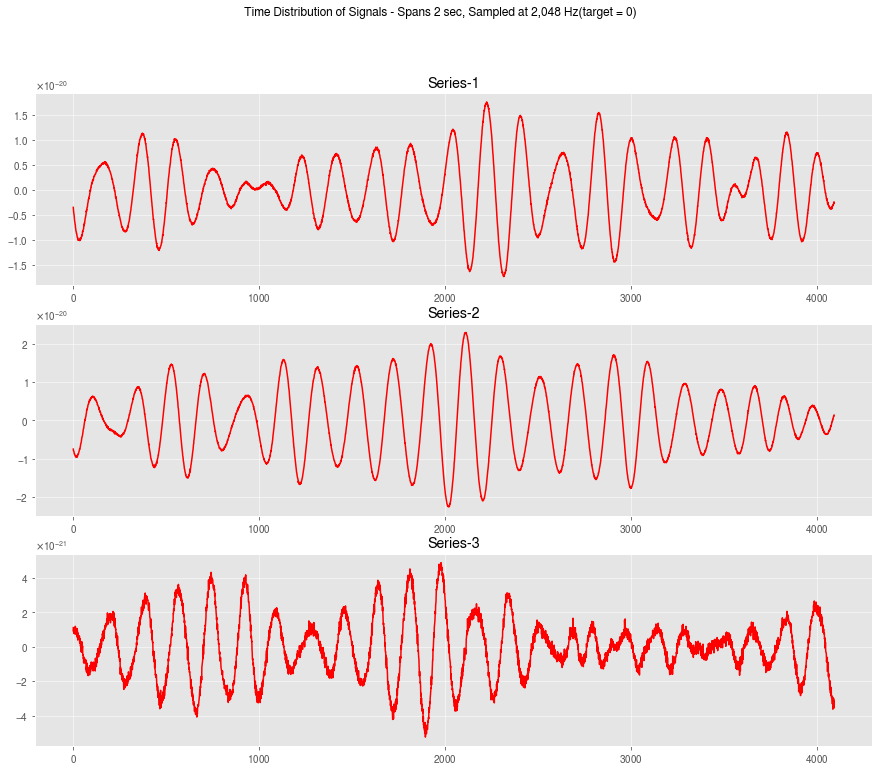

In [15]:
# Extract 1 random element from the target_0_df_train
# using random_state to ensure the reproducibility of the examples.
target_0_rand_sample_file = target_0_df_train.sample(1).path.values[0]
print(target_0_rand_sample_file)

selected_rand_series_0 = np.load(target_0_rand_sample_file)

multi_plot(selected_rand_series_0, 'time', "0")


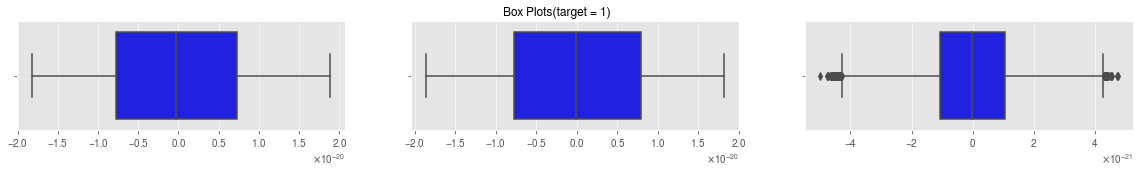

In [16]:
multi_plot(selected_rand_series_1, "box", "1")

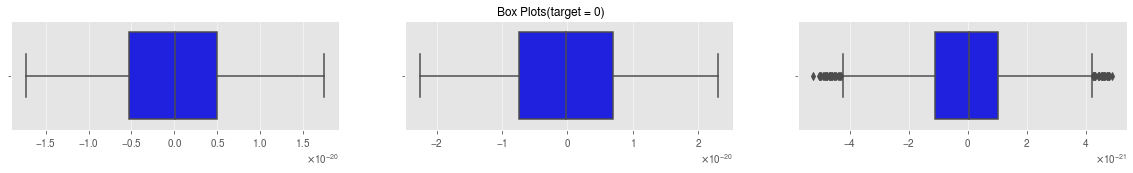

In [17]:
multi_plot(selected_rand_series_0, 'box', "0")

**Basic observation from Box Plots:**
1. The 3 series from the 3 Interferometer have fairly similar distribution for both the class types.

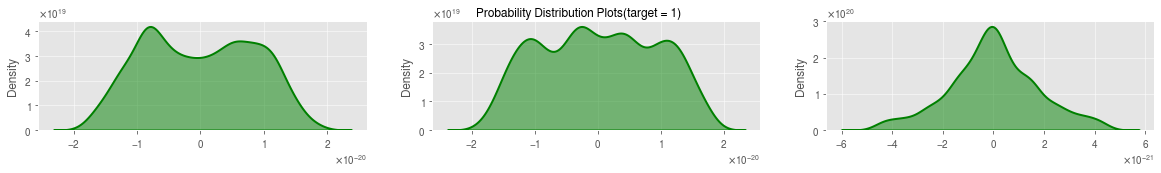

In [18]:
multi_plot(selected_rand_series_1, 'kde', "1")

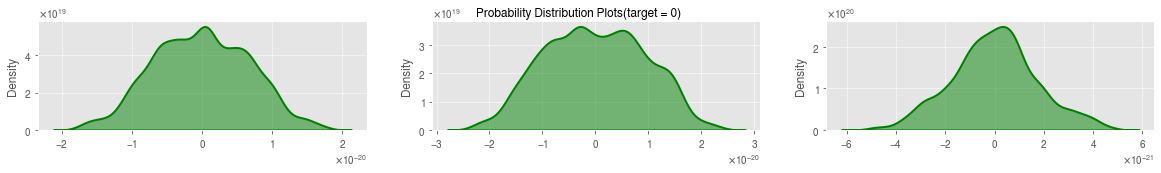

In [19]:
multi_plot(selected_rand_series_0, 'kde', "0")


## Note on Keras Sequential model

There are two ways to build Keras models: sequential and functional.

**The sequential API** allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.
In short, you create a sequential model where you can easily add layers, and each layer can have convolution, max pooling, activation, drop-­out, and batch normalization.

Alternatively, **the functional API** allows you to create models that have a lot more flexibility as you can easily define models where layers connect to more than just the previous and next layers. In fact, you can connect layers to (literally) any other layer. As a result, creating complex networks such as siamese networks and residual networks become possible.

From the definition of Keras documentation the Sequential model is a linear stack of layers. You can create a Sequential model by passing a list of layer instances to the constructor. The common architecture of ConvNets is a sequential architecture. However, some architectures are not linear stacks. For example, siamese networks are two parallel neural networks with some shared layers.

With the Sequential Models, you need to ensure the
input layer has the right number of inputs. Assume that you have 3,072
input variables; then you need to create the first hidden layer with 512
nodes/neurons. In the second hidden layer, you have 120 nodes/neurons.
Finally, you have ten nodes in the output layer. For example, an image
maps onto ten nodes that shows the probability of being label1 (airplane),
label2 (automobile), label3 (cat), ..., label10 (truck). The node of highest
probability is the predicted class/label.


### Some common layer types in Keras are as follows:

**Dense**: This is a fully connected layer in which all the nodes of the layer are
directly connected to all the inputs and all the outputs. ANNs for classification or
regression tasks on tabular data usually have a large percentage of their layers with
this type in the architecture.

**Convolutional**: This layer type creates a convolutional kernel that is convolved with
the input layer to produce a tensor of outputs. This convolution can occur in one
or multiple dimensions. ANNs for the classification of images usually feature one or
more convolutional layers in their architecture.

**Pooling**: This type of layer is used to reduce the dimensionality of an input layer.
Common types of pooling include max pooling, in which the maximum value of
a given window is passed through to the output, or average pooling, in which
the average value of a window is passed through. These layers are often used
in conjunction with a convolutional layer, and their purpose is to reduce the
dimensions of the subsequent layers, allowing for fewer training parameters to be
learned with little information loss.

**Recurrent**: Recurrent layers learn patterns from sequences, so each output is
dependent on the results from the previous step. ANNs that model sequential data
such as natural language or time-series data often feature one or more recurrent
layer types.


There are other layer types in Keras; however, these are the most common types when
it comes to building models using Keras.


## Why I would need a Custom Data Generator Function for Keras Sequential Model building

The key reason is to be able to handle large data with batching, so the RAM/CPU/GPU does not need to handle the full data at once, which will anyway not be possible for this 72GB dataset.

So basically, since our code will in most cases be multicore-friendly, so we focus on doing more complex operations (e.g. computations from source files) without worrying about data generation becoming a bottleneck in the training process.


**DataGenerator(Sequence)** => Now, let's go through the details of how to set the Python class DataGenerator, which will be used for real-time data feeding to your Keras model. We make `DataGenerator` inherit the properties of `keras.utils.Sequence` so that we can leverage nice functionalities such as multiprocessing.

While we have built-in Data Generator like [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), we still need a plethora of custom Generator function. Because, Model training is not limited to a single type of input and target. There are times when a model is fed with multiple types of inputs at once. For example, say in a multi-modal classification problem which needs to process text and image data simultaneously. Here, obviously we cannot use ImageDataGenerator. Hence, we need a custom data generator.

According to [Keras Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) - Every Sequence must implement the `__getitem__` and the `__len__` methods. If you want to modify your dataset between epochs you may implement on_epoch_end. The method __getitem__ should return a complete batch.

 ### A note on `yield` function with respect to the custom data generator here for Sequence API of Keras

Here I am using the Sequence API, which works a bit different than plain generators. In a generator function, you would use the `yield` keyword to perform iteration inside a while True: loop, so each time Keras calls the generator, it gets a batch of data and it automatically wraps around the end of the data.

But in a Sequence-API, there is an index parameter to the `__getitem__` function, so no iteration or `yield` is required, this is performed by Keras for you. This is made so the sequence can run in parallel using multiprocessing, which is not possible with old generator functions.

---

### Difference between fit() and fit_generator() in Keras

In Keras, using fit() and predict() is fine for smaller datasets which can be loaded into memory. But in practice, for most practical-use cases, almost all datasets are large and cannot be loaded into memory at once. The solution is to use fit_generator() and predict_generator() with custom data generator functions which can load data to memory during training or predicting.

In keras, fit() is much similar to sklearn's fit method, where you pass array of features as x values and target as y values. You pass your whole dataset at once in fit method. Also, use it if you can load whole data into your memory (small dataset).

In fit_generator(), you don't pass the x and y directly, instead they come from a generator. As it is written in keras documentation, generator is used when you want to avoid duplicate data when using multiprocessing. This is for practical purpose, when you have large dataset.

In [20]:
""" First, we define the constructor to initialize the configuration of the generator.
Note that here, we assume the path to the data is in a dataframe column.

"""

class DataGenerator(Sequence):
    """
    Custom data generator for loading and processing time-series data.

    Args:
        path (str): Path to the data files.
        list_IDs (list): List of file IDs.
        data (pandas.DataFrame): DataFrame containing the data and labels.
        batch_size (int): Batch size for the generator.

    Attributes:
        path (str): Path to the data files.
        list_IDs (list): List of file IDs.
        data (pandas.DataFrame): DataFrame containing the data and labels.
        batch_size (int): Batch size for the generator.
        indexes (numpy.ndarray): Array of indexes for shuffling the data.

    Methods:
        __len__(): Returns the number of steps in an epoch.
        __getitem__(index): Generates a given batch of data.
        __data_generation(list_IDs_temp): Generates the data and labels for a batch.

    """

    # For this dataset the list_IDs are the value of the ids
    # for each of the time-series file
    # i.e. for Train data => values of column 'id' from training_labels.csv

    # Also Note we have earlier defined our labels to be the below
    # labels = pd.read_csv(root_dir + "training_labels.csv")
    # and the argument "data" is that label here.
    def __init__(self, path, list_IDs, data, batch_size):
        """
        Initialize the data generator.

        Args:
            path (str): Path to the data files.
            list_IDs (list): List of file IDs.
            data (pandas.DataFrame): DataFrame containing the data and labels.
            batch_size (int): Batch size for the generator.

        """
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))

    """ __len__ essentially returns the number of steps in an epoch, using the samples and the batch size.
        Each call requests a batch index between 0 and the total number of batches, where the latter is specified in the __len__ method.
        A common practice is to set this value to (samples / batch size)
        so that the model sees the training samples at most once per epoch.
        Now, when the batch corresponding to a given index is called, the generator executes the __getitem__ method to generate it.
    """

    def __len__(self):
        """
        Returns the number of steps in an epoch.

        Returns:
            int: Number of steps in an epoch.

        """
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_ * self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_

    def __getitem__(self, index):
        """
        __getitem__ method is called with the batch number as an argument to obtain a given batch of data.

        Args:
            index (int): Index of the batch.

        Returns:
            tuple: Tuple containing the input data and labels.

        """
        # get the range to to feed to keras for each epoch
        # incrementing by +1 the bath_size
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    """ And finally the core method which will actually produce batches of data. This private method __data_generation """

    def __data_generation(self, list_IDs_temp):
        # We have 5,60,000 files, each with dimension of 3 * 4096
        X = np.zeros((self.batch_size, 3, 4096))
        y = np.zeros((self.batch_size, 1))
        for i, ID in enumerate(list_IDs_temp):
            id_ = self.data.loc[ID, "id"]
            file = id_ + ".npy"  # build the file name
            path_in = "/".join([self.path, id_[0], id_[1], id_[2]]) + "/"
            # there are three nesting labels inside train/ or test/
            data_array = np.load(path_in + file)            
            data_array = (data_array - data_array.mean())/data_array.std()
            X[i, ] = data_array
            y[i, ] = self.data.loc[ID, 'target']
        # print(X)
        return X, y

In [21]:
sample_submission = pd.read_csv(root_dir +  'sample_submission.csv')
# print(len(train_labels)) # 5,60,000
# print(len(sample_submission)) # 2,26,000
train_ids = train_labels['id'].values
# train_ids # ['00000e74ad', '00001f4945', '0000661522' ... ]
y = train_labels['target'].values
test_ids = sample_submission['id'].values

In [22]:
# train_labels = pd.read_csv(root_dir + "training_labels.csv", nrows=1000)

# ********************

# Now I shall genereate train indices, validation indices and test indices
# Which are just the values from the 0-based indices
train_indices, validation_indices = train_test_split(list(train_labels.index), test_size=0.33, random_state=2021)
# print(len(train_indices))
print(len(validation_indices))
test_indices = list(sample_submission.index)
# test_indices

184800


In [23]:

train_generator_for_seq_model = DataGenerator( root_dir +  'train/', train_indices, train_labels, 64)
# print(train_generator_for_seq_model)
validation_generator_for_seq_model = DataGenerator( root_dir + 'train/', validation_indices, train_labels, 64)
test_generator_for_seq_model = DataGenerator( root_dir + 'test/', test_indices, sample_submission, 64)

In [24]:
model_keras_seq = Sequential()
model_keras_seq.add(Conv1D(64, input_shape=(3, 4096), kernel_size=3, activation='relu'))
model_keras_seq.add(BatchNormalization())
model_keras_seq.add(Flatten())
model_keras_seq.add(Dense(64, activation='relu'))
model_keras_seq.add(Dense(1, activation='sigmoid'))

model_keras_seq.compile(optimizer= Adam(lr=2e-4), loss='binary_crossentropy', metrics=['acc'])
model_keras_seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             786496    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 64)             256       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 790,977
Trainable params: 790,849
Non-trainable params: 128
_________________________________________________________________


2021-08-25 20:06:50.739056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-25 20:06:50.739411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-25 20:06:50.739499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-08-25 20:06:50.739574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-08-25 20:06:50.739640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [25]:
history = model_keras_seq.fit_generator(generator=train_generator_for_seq_model, validation_data=validation_generator_for_seq_model, epochs = 1, workers=-1)
# Running for 1 epoch took almost 2 and half hours.

predicted_test_seq_keras = model_keras_seq.predict_generator(test_generator_for_seq_model, verbose=1)

sample_submission['target'] = predicted_test_seq_keras[:len(sample_submission)]

sample_submission.to_csv('submission.csv', index=False)